In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
dataset = pd.read_csv('eth-usd-max.csv', parse_dates = True)
dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace = True)
prices = pd.DataFrame(dataset['price'])
print(dataset)

                  price    market_cap  total_volume
Date                                               
2015-08-07     2.831620  0.000000e+00  9.062200e+04
2015-08-08     1.330750  8.033948e+07  3.680700e+05
2015-08-10     0.687586  4.155631e+07  4.004641e+05
2015-08-11     1.067379  6.453901e+07  1.518998e+06
2015-08-12     1.256613  7.601326e+07  2.073893e+06
...                 ...           ...           ...
2024-12-23  3275.889427  3.949847e+11  2.581140e+10
2024-12-24  3414.641442  4.114230e+11  3.552807e+10
2024-12-25  3497.555288  4.207081e+11  2.408525e+10
2024-12-26  3494.510927  4.210295e+11  1.750380e+10
2024-12-27  3327.789776  4.010384e+11  2.123998e+10

[3430 rows x 3 columns]


BTC Seasonal Decomposition


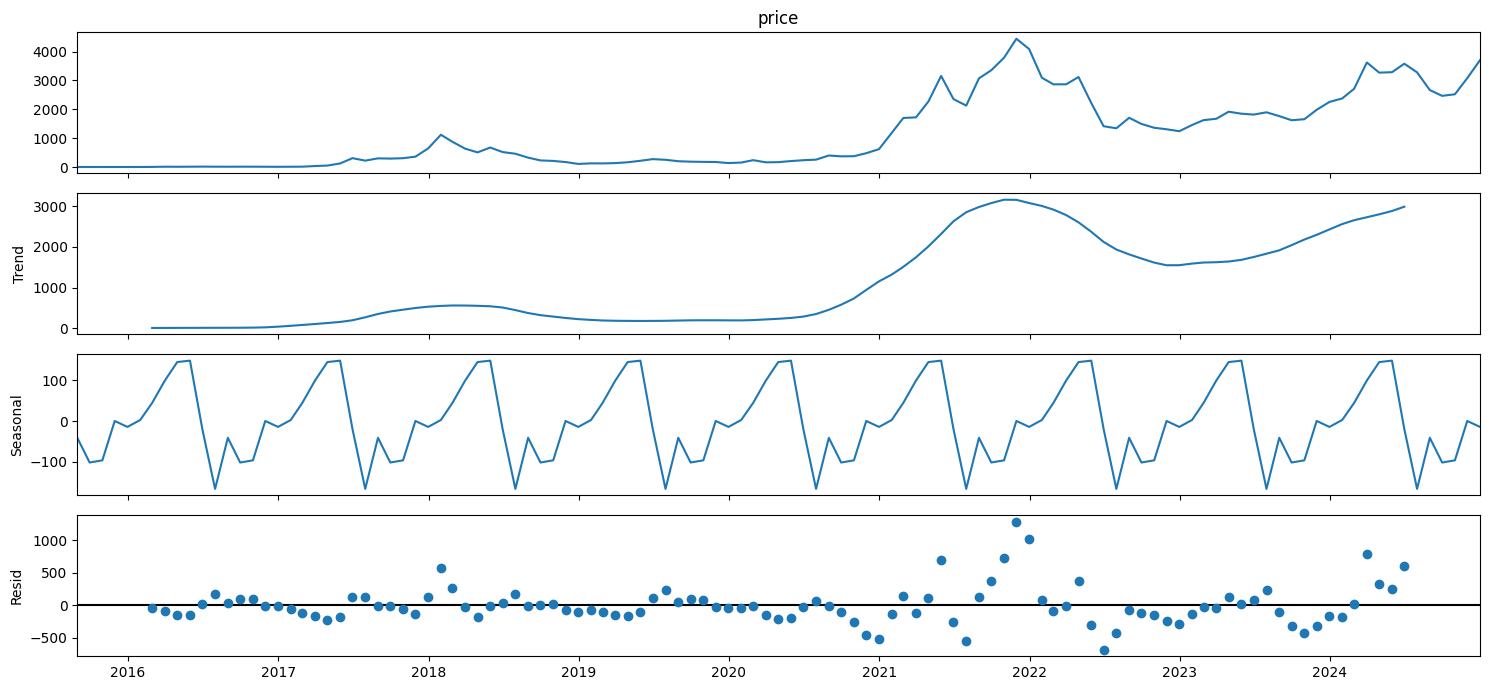

In [6]:
# Function to Plot
plt.rcParams["figure.figsize"]=(15,7)

def season_df(data, label):
    df=data.resample("ME").mean()
    seasonal_decompose(df.price).plot()
    print(label)
    return plt.show()

season_df(data=dataset, label="BTC Seasonal Decomposition")

In [7]:
#Box-Cox Transformation
btc_month=prices.resample("ME").mean()
btc_month["close_box"], lmbda=stats.boxcox(btc_month.price)

In [8]:
btc_month

,price,close_box
Date,,
2015-08-31,1.376541,0.332722
2015-09-30,0.986848,-0.013218
2015-10-31,0.659398,-0.395432
2015-11-30,0.929560,-0.072380
2015-12-31,0.886376,-0.118809
...,...,...
2024-08-31,2665.399601,24.824883
2024-09-30,2464.412669,24.264162
2024-10-31,2520.049292,24.422710


In [9]:
btc_month_train = btc_month[:-12]
btc_month_test = btc_month[-12:]

In [10]:
btc_month_train.tail()

,price,close_box
Date,,
2023-08-31,1763.532890,21.990964
2023-09-30,1620.260100,21.444991
2023-10-31,1655.403695,21.582162
2023-11-30,1981.823335,22.762146
2023-12-31,2253.876131,23.638755


In [11]:
btc_month_test

,price,close_box
Date,,
2024-01-31,2375.274045,24.004459
2024-02-29,2710.269549,24.945709
2024-03-31,3620.128873,27.123150
2024-04-30,3268.738030,26.336974
2024-05-31,3283.440939,26.371109
2024-06-30,3577.871486,27.031717
2024-07-31,3278.279145,26.359138
2024-08-31,2665.399601,24.824883
2024-09-30,2464.412669,24.264162


In [14]:
best_model = SARIMAX(btc_month_train.close_box, order=(1, 1, 1), seasonal_order=(1,1,1,48)).fit(disp=-1)

In [25]:
btc_month_train

,price,close_box
Date,,
2015-08-31,1.376541,0.332722
2015-09-30,0.986848,-0.013218
2015-10-31,0.659398,-0.395432
2015-11-30,0.929560,-0.072380
2015-12-31,0.886376,-0.118809
...,...,...
2023-08-31,1763.532890,21.990964
2023-09-30,1620.260100,21.444991
2023-10-31,1655.403695,21.582162


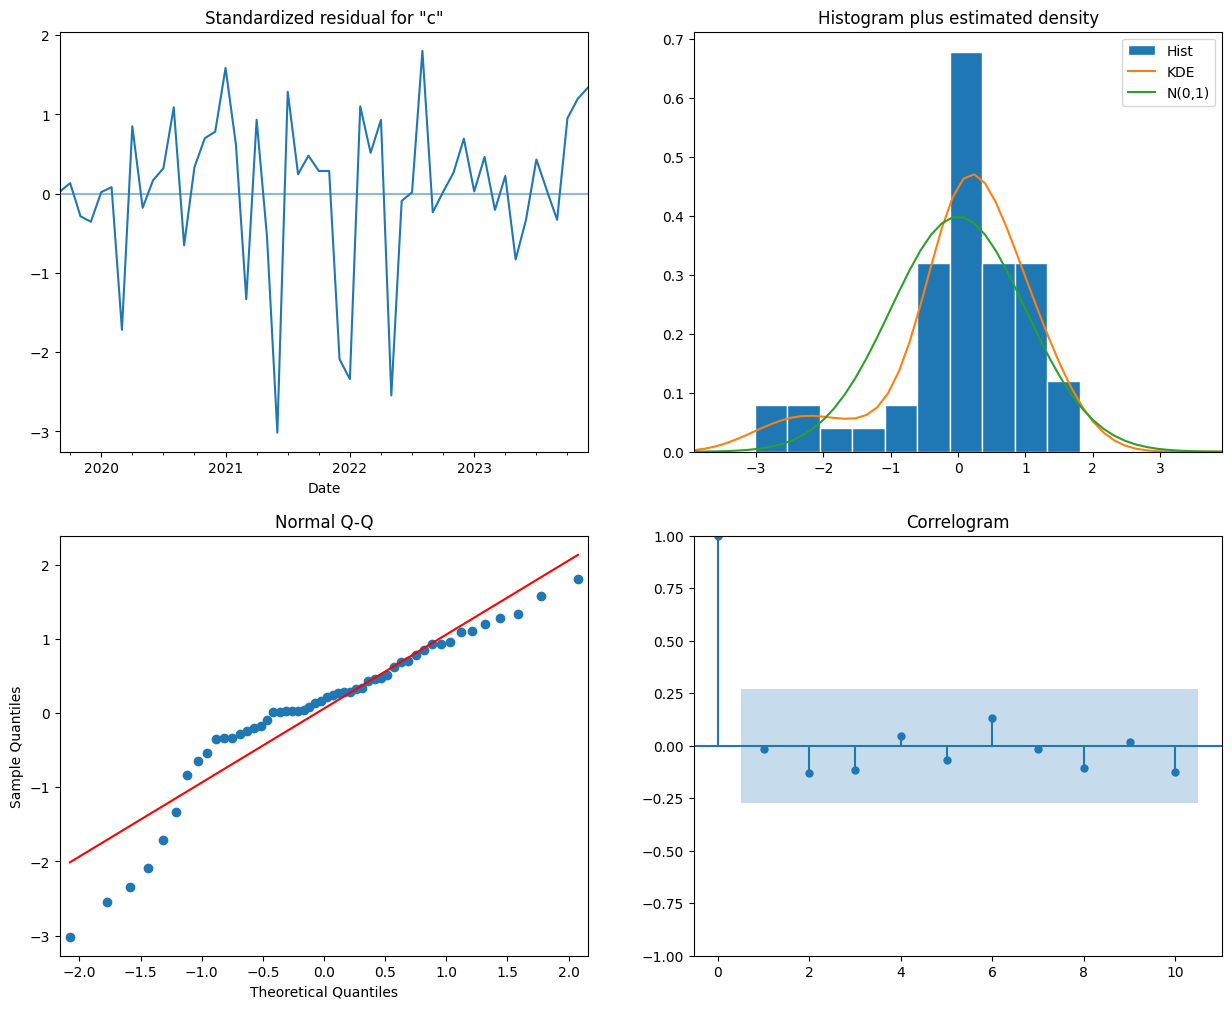

In [15]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [17]:

btc_month['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 4, 30), end=datetime(2029, 3, 31)), lmbda)

In [18]:
pred = invboxcox(best_model.predict(start=datetime(2018, 4, 30), end=datetime(2029, 3, 31)), lmbda)

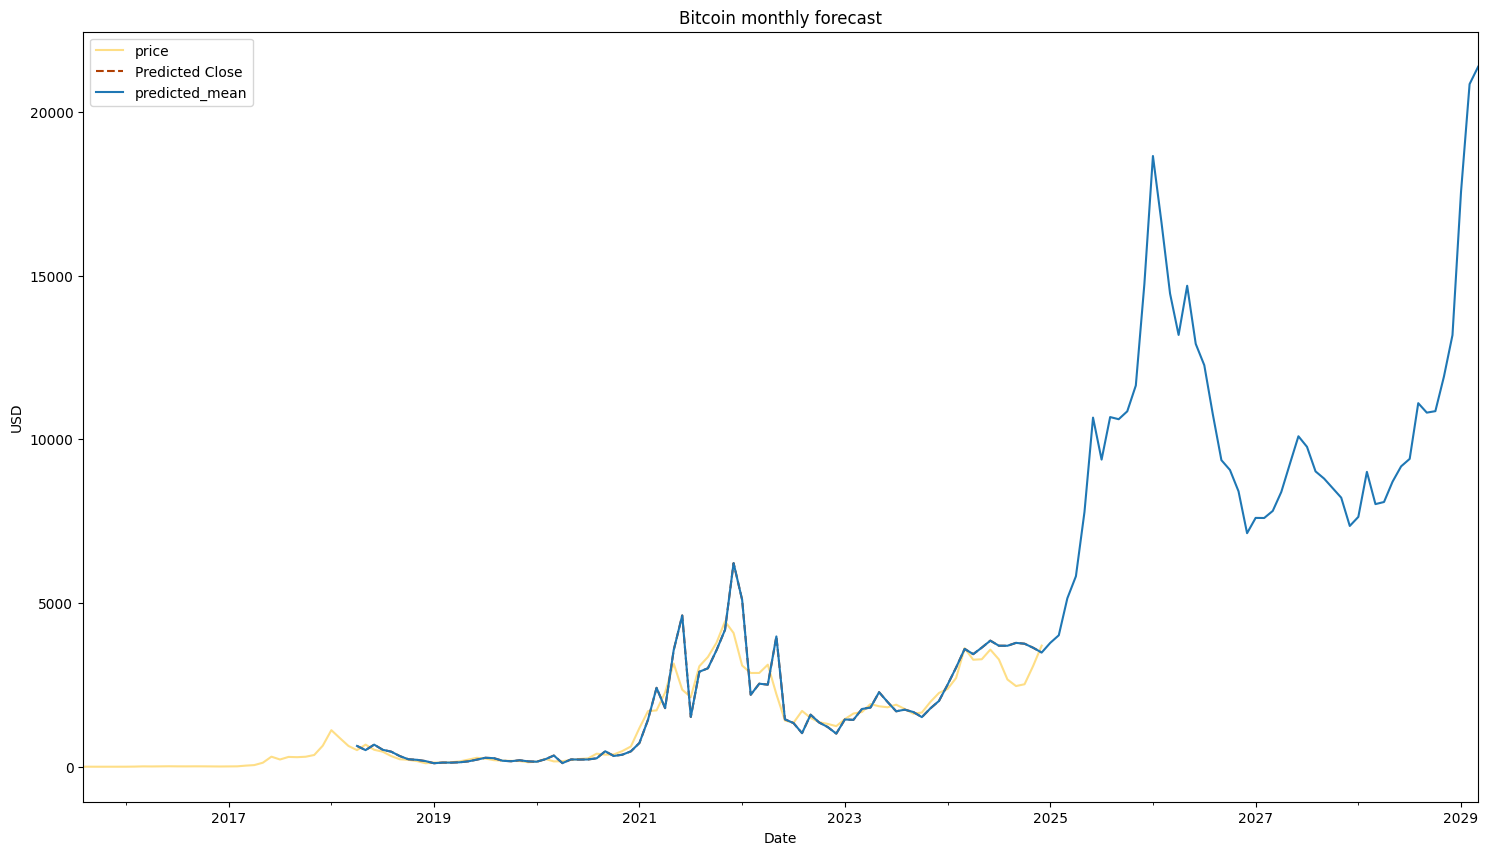

In [24]:
plt.figure(figsize=(18,10))
btc_month.price.plot(color='#fede86')
btc_month.forecast.plot(color='#b03f03', ls='--', label='Predicted Close')
pred.plot()
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

In [20]:
y_test_actual = btc_month['price'][datetime(2018, 4, 30):]
y_pred_actual = btc_month['forecast'][datetime(2018, 4, 30):]

In [21]:
y_test_actual

Date
2018-04-30     507.720136
2018-05-31     675.411000
2018-06-30     518.902844
2018-07-31     460.134271
2018-08-31     325.346844
                 ...     
2024-08-31    2665.399601
2024-09-30    2464.412669
2024-10-31    2520.049292
2024-11-30    3077.433517
2024-12-31    3699.612612
Freq: ME, Name: price, Length: 81, dtype: float64

In [22]:
y_pred_actual

Date
2018-04-30     635.602504
2018-05-31     507.720055
2018-06-30     675.411181
2018-07-31     518.902693
2018-08-31     460.134247
                 ...     
2024-08-31    3695.329439
2024-09-30    3783.402107
2024-10-31    3757.893649
2024-11-30    3634.794952
2024-12-31    3488.239832
Freq: ME, Name: forecast, Length: 81, dtype: float64

In [23]:
def mape(datatest, datapred): 
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)
    
print('Mean Absolute Percentage Error : ', mape(y_test_actual, y_pred_actual), '%')

Mean Absolute Percentage Error :  20.5242 %
